In [1]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTFeatureExtractor
import time

2024-10-13 12:09:06.622567: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-10-13 12:09:06.645939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.

To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

2024-10-13 12:09:07.057990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import random

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = []
        
        for class_idx, class_name in enumerate(os.listdir(img_dir)):
            class_folder = os.path.join(img_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.img_labels.append((img_path, class_idx))
                    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
dataper = [0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3]

In [4]:
img_dir = '/home/buddha/Desktop/Satvik/PBC_dataset_normal_DIB/'  
dataset = CustomImageDataset(img_dir, transform=transform)

In [5]:
dataset_size = len(dataset)

In [6]:
test_size = 4000
validation_size = 1700
val_test_set, train_set_main = random_split(dataset, [validation_size+test_size, len(dataset) - (validation_size+test_size)])
val_set, test_set = random_split(val_test_set, [validation_size, test_size])

In [7]:
time_data = {
    'Data Split' : [f'{i*100}%' for i in dataper],
    'Validation size' : [validation_size for i in range(len(dataper))],
    'Test size' : [test_size for i in range(len(dataper))],
    'Train size' : [int(i * dataset_size) for i in dataper],
    'Time Taken' : []
}
time_per_datasplit_per_epoch = []
save_model = []
train_loss_all =[]
train_acc_all= []
val_loss_all = []
val_acc_all = []

for i in dataper:
    train_loss_per =[]
    train_acc_per= []
    val_loss_per = []
    val_acc_per = []
    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224',
        num_labels=8,  # 8 classes
        ignore_mismatched_sizes=True 
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_size = int(i * dataset_size)
    train_set, _ = random_split(train_set_main, [train_size, len(train_set_main) - train_size])
    print(len(train_set))
    batch_size = 4
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    import torch.optim as optim
    from tqdm import tqdm

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    time_epoch = []
    
    def train(model, train_loader, val_loader, epochs=15):
        for epoch in range(epochs):
            torch.cuda.empty_cache()
            t_epoch = time.time()
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in tqdm(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_acc = 100. * correct / total
            val_loss, val_acc = validate(model, val_loader)
            
            
            
            train_loss_per.append(train_loss)
            train_acc_per.append(train_acc)
            val_loss_per.append(val_loss)
            val_acc_per.append(val_acc)

            print(f'Epoch [{epoch+1}/{epochs}] '
                  f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% '
                  f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
            time_epoch.append(time.time() - t_epoch)

    def validate(model, val_loader):
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        accuracy = 100. * correct / total

        return avg_val_loss, accuracy
    
    t0 = time.time()
    train(model, train_loader, val_loader, epochs=15)
    time_data['Time Taken'].append(time.time()-t0)
    
    train_loss_all.append(train_loss_per)
    train_acc_all.append(train_acc_per)
    val_loss_all.append(val_loss_per)
    val_acc_all.append(val_acc_per)
    
    time_per_datasplit_per_epoch.append(time_epoch)
    model.to('cpu')
    save_model.append(model)
    
    # Explicitly delete the model to free GPU memory
    del model
    # Clear the CUDA cache to release unused memory
    torch.cuda.empty_cache()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


170


100%|███████████████████████████████████████████| 43/43 [00:14<00:00,  2.89it/s]


Epoch [1/15] Train Loss: 1.7102 | Train Acc: 34.71% | Val Loss: 1.1351 | Val Acc: 51.76%


100%|███████████████████████████████████████████| 43/43 [00:13<00:00,  3.27it/s]


Epoch [2/15] Train Loss: 0.8422 | Train Acc: 69.41% | Val Loss: 0.7480 | Val Acc: 74.00%


100%|███████████████████████████████████████████| 43/43 [00:12<00:00,  3.34it/s]


Epoch [3/15] Train Loss: 0.3364 | Train Acc: 88.24% | Val Loss: 1.0477 | Val Acc: 76.35%


100%|███████████████████████████████████████████| 43/43 [00:12<00:00,  3.37it/s]


Epoch [4/15] Train Loss: 0.3399 | Train Acc: 90.00% | Val Loss: 0.4506 | Val Acc: 85.18%


100%|███████████████████████████████████████████| 43/43 [00:13<00:00,  3.31it/s]


Epoch [5/15] Train Loss: 0.1437 | Train Acc: 97.06% | Val Loss: 0.9452 | Val Acc: 68.65%


100%|███████████████████████████████████████████| 43/43 [00:12<00:00,  3.36it/s]


Epoch [6/15] Train Loss: 0.1678 | Train Acc: 94.12% | Val Loss: 0.8216 | Val Acc: 76.88%


100%|███████████████████████████████████████████| 43/43 [00:12<00:00,  3.35it/s]


Epoch [7/15] Train Loss: 0.0552 | Train Acc: 98.82% | Val Loss: 0.4702 | Val Acc: 86.18%


100%|███████████████████████████████████████████| 43/43 [00:12<00:00,  3.33it/s]


Epoch [8/15] Train Loss: 0.0042 | Train Acc: 100.00% | Val Loss: 0.4452 | Val Acc: 87.53%


100%|███████████████████████████████████████████| 43/43 [00:12<00:00,  3.36it/s]


Epoch [9/15] Train Loss: 0.0023 | Train Acc: 100.00% | Val Loss: 0.4478 | Val Acc: 87.76%


100%|███████████████████████████████████████████| 43/43 [00:11<00:00,  3.67it/s]


Epoch [10/15] Train Loss: 0.0019 | Train Acc: 100.00% | Val Loss: 0.4493 | Val Acc: 87.82%


100%|███████████████████████████████████████████| 43/43 [00:11<00:00,  3.79it/s]


Epoch [11/15] Train Loss: 0.0016 | Train Acc: 100.00% | Val Loss: 0.4545 | Val Acc: 87.88%


100%|███████████████████████████████████████████| 43/43 [00:11<00:00,  3.73it/s]


Epoch [12/15] Train Loss: 0.0013 | Train Acc: 100.00% | Val Loss: 0.4577 | Val Acc: 87.88%


100%|███████████████████████████████████████████| 43/43 [00:13<00:00,  3.15it/s]


Epoch [13/15] Train Loss: 0.0012 | Train Acc: 100.00% | Val Loss: 0.4623 | Val Acc: 87.82%


100%|███████████████████████████████████████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch [14/15] Train Loss: 0.0010 | Train Acc: 100.00% | Val Loss: 0.4657 | Val Acc: 87.71%


100%|███████████████████████████████████████████| 43/43 [00:12<00:00,  3.32it/s]


Epoch [15/15] Train Loss: 0.0009 | Train Acc: 100.00% | Val Loss: 0.4692 | Val Acc: 87.65%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


427


100%|█████████████████████████████████████████| 107/107 [00:31<00:00,  3.43it/s]


Epoch [1/15] Train Loss: 1.1677 | Train Acc: 56.91% | Val Loss: 0.4831 | Val Acc: 84.00%


100%|█████████████████████████████████████████| 107/107 [00:31<00:00,  3.44it/s]


Epoch [2/15] Train Loss: 0.3271 | Train Acc: 88.99% | Val Loss: 1.1222 | Val Acc: 72.65%


100%|█████████████████████████████████████████| 107/107 [00:33<00:00,  3.24it/s]


Epoch [3/15] Train Loss: 0.2258 | Train Acc: 92.97% | Val Loss: 0.3440 | Val Acc: 88.24%


100%|█████████████████████████████████████████| 107/107 [00:33<00:00,  3.23it/s]


Epoch [4/15] Train Loss: 0.1233 | Train Acc: 97.42% | Val Loss: 0.3320 | Val Acc: 90.00%


100%|█████████████████████████████████████████| 107/107 [00:34<00:00,  3.15it/s]


Epoch [5/15] Train Loss: 0.0138 | Train Acc: 99.77% | Val Loss: 0.1865 | Val Acc: 94.41%


100%|█████████████████████████████████████████| 107/107 [00:15<00:00,  6.83it/s]


Epoch [6/15] Train Loss: 0.0019 | Train Acc: 100.00% | Val Loss: 0.1895 | Val Acc: 94.65%


100%|█████████████████████████████████████████| 107/107 [00:15<00:00,  6.80it/s]


Epoch [7/15] Train Loss: 0.0013 | Train Acc: 100.00% | Val Loss: 0.1945 | Val Acc: 94.65%


100%|█████████████████████████████████████████| 107/107 [00:15<00:00,  6.82it/s]


Epoch [8/15] Train Loss: 0.0010 | Train Acc: 100.00% | Val Loss: 0.1989 | Val Acc: 94.65%


100%|█████████████████████████████████████████| 107/107 [00:15<00:00,  6.82it/s]


Epoch [9/15] Train Loss: 0.0008 | Train Acc: 100.00% | Val Loss: 0.2031 | Val Acc: 94.65%


100%|█████████████████████████████████████████| 107/107 [00:15<00:00,  6.83it/s]


Epoch [10/15] Train Loss: 0.0007 | Train Acc: 100.00% | Val Loss: 0.2070 | Val Acc: 94.65%


100%|█████████████████████████████████████████| 107/107 [00:15<00:00,  6.83it/s]


Epoch [11/15] Train Loss: 0.0005 | Train Acc: 100.00% | Val Loss: 0.2108 | Val Acc: 94.65%


100%|█████████████████████████████████████████| 107/107 [00:15<00:00,  6.81it/s]


Epoch [12/15] Train Loss: 0.0005 | Train Acc: 100.00% | Val Loss: 0.2138 | Val Acc: 94.71%


100%|█████████████████████████████████████████| 107/107 [00:15<00:00,  6.81it/s]


Epoch [13/15] Train Loss: 0.0004 | Train Acc: 100.00% | Val Loss: 0.2169 | Val Acc: 94.71%


100%|█████████████████████████████████████████| 107/107 [00:15<00:00,  6.82it/s]


Epoch [14/15] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.2197 | Val Acc: 94.71%


100%|█████████████████████████████████████████| 107/107 [00:15<00:00,  6.80it/s]


Epoch [15/15] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.2223 | Val Acc: 94.71%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


854


100%|█████████████████████████████████████████| 214/214 [00:32<00:00,  6.68it/s]


Epoch [1/15] Train Loss: 0.6542 | Train Acc: 79.39% | Val Loss: 0.2286 | Val Acc: 93.29%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.82it/s]


Epoch [2/15] Train Loss: 0.1686 | Train Acc: 94.61% | Val Loss: 0.1512 | Val Acc: 95.24%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.82it/s]


Epoch [3/15] Train Loss: 0.0563 | Train Acc: 98.48% | Val Loss: 0.1998 | Val Acc: 94.00%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.77it/s]


Epoch [4/15] Train Loss: 0.0164 | Train Acc: 99.53% | Val Loss: 0.2711 | Val Acc: 91.59%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.77it/s]


Epoch [5/15] Train Loss: 0.1442 | Train Acc: 95.67% | Val Loss: 0.4886 | Val Acc: 86.76%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.78it/s]


Epoch [6/15] Train Loss: 0.0651 | Train Acc: 98.13% | Val Loss: 0.3187 | Val Acc: 93.12%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.76it/s]


Epoch [7/15] Train Loss: 0.1422 | Train Acc: 96.37% | Val Loss: 0.3031 | Val Acc: 90.12%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.78it/s]


Epoch [8/15] Train Loss: 0.0324 | Train Acc: 99.18% | Val Loss: 0.1876 | Val Acc: 94.88%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.75it/s]


Epoch [9/15] Train Loss: 0.0010 | Train Acc: 100.00% | Val Loss: 0.1837 | Val Acc: 95.06%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.82it/s]


Epoch [10/15] Train Loss: 0.0007 | Train Acc: 100.00% | Val Loss: 0.1862 | Val Acc: 95.12%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.82it/s]


Epoch [11/15] Train Loss: 0.0005 | Train Acc: 100.00% | Val Loss: 0.1887 | Val Acc: 95.24%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.82it/s]


Epoch [12/15] Train Loss: 0.0004 | Train Acc: 100.00% | Val Loss: 0.1910 | Val Acc: 95.35%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.83it/s]


Epoch [13/15] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.1931 | Val Acc: 95.41%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.83it/s]


Epoch [14/15] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.1951 | Val Acc: 95.41%


100%|█████████████████████████████████████████| 214/214 [00:31<00:00,  6.81it/s]


Epoch [15/15] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.1976 | Val Acc: 95.41%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1281


100%|█████████████████████████████████████████| 321/321 [00:47<00:00,  6.74it/s]


Epoch [1/15] Train Loss: 0.5745 | Train Acc: 80.09% | Val Loss: 0.2491 | Val Acc: 91.47%


100%|█████████████████████████████████████████| 321/321 [00:46<00:00,  6.86it/s]


Epoch [2/15] Train Loss: 0.2026 | Train Acc: 93.52% | Val Loss: 0.2144 | Val Acc: 93.06%


100%|█████████████████████████████████████████| 321/321 [00:47<00:00,  6.78it/s]


Epoch [3/15] Train Loss: 0.0886 | Train Acc: 96.80% | Val Loss: 0.2915 | Val Acc: 91.82%


100%|█████████████████████████████████████████| 321/321 [00:47<00:00,  6.81it/s]


Epoch [4/15] Train Loss: 0.0839 | Train Acc: 97.35% | Val Loss: 0.6473 | Val Acc: 85.12%


100%|█████████████████████████████████████████| 321/321 [00:47<00:00,  6.75it/s]


Epoch [5/15] Train Loss: 0.0868 | Train Acc: 97.66% | Val Loss: 0.3137 | Val Acc: 91.29%


100%|█████████████████████████████████████████| 321/321 [01:39<00:00,  3.22it/s]


Epoch [6/15] Train Loss: 0.0182 | Train Acc: 99.45% | Val Loss: 0.2082 | Val Acc: 94.76%


100%|█████████████████████████████████████████| 321/321 [01:40<00:00,  3.19it/s]


Epoch [7/15] Train Loss: 0.0006 | Train Acc: 100.00% | Val Loss: 0.2119 | Val Acc: 94.94%


100%|█████████████████████████████████████████| 321/321 [01:41<00:00,  3.16it/s]


Epoch [8/15] Train Loss: 0.0004 | Train Acc: 100.00% | Val Loss: 0.2158 | Val Acc: 94.94%


100%|█████████████████████████████████████████| 321/321 [01:36<00:00,  3.33it/s]


Epoch [9/15] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.2194 | Val Acc: 94.94%


100%|█████████████████████████████████████████| 321/321 [01:37<00:00,  3.28it/s]


Epoch [10/15] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.2231 | Val Acc: 95.00%


100%|█████████████████████████████████████████| 321/321 [01:37<00:00,  3.28it/s]


Epoch [11/15] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.2262 | Val Acc: 95.00%


100%|█████████████████████████████████████████| 321/321 [01:38<00:00,  3.27it/s]


Epoch [12/15] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.2296 | Val Acc: 95.00%


100%|█████████████████████████████████████████| 321/321 [01:37<00:00,  3.30it/s]


Epoch [13/15] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.2324 | Val Acc: 95.24%


100%|█████████████████████████████████████████| 321/321 [01:37<00:00,  3.29it/s]


Epoch [14/15] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.2355 | Val Acc: 95.35%


100%|█████████████████████████████████████████| 321/321 [01:37<00:00,  3.28it/s]


Epoch [15/15] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.2388 | Val Acc: 95.35%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1709


100%|█████████████████████████████████████████| 428/428 [02:09<00:00,  3.30it/s]


Epoch [1/15] Train Loss: 0.5292 | Train Acc: 83.03% | Val Loss: 0.3473 | Val Acc: 88.71%


100%|█████████████████████████████████████████| 428/428 [02:12<00:00,  3.23it/s]


Epoch [2/15] Train Loss: 0.1770 | Train Acc: 94.73% | Val Loss: 0.2368 | Val Acc: 92.18%


100%|█████████████████████████████████████████| 428/428 [02:09<00:00,  3.32it/s]


Epoch [3/15] Train Loss: 0.0822 | Train Acc: 97.19% | Val Loss: 0.3014 | Val Acc: 91.35%


100%|█████████████████████████████████████████| 428/428 [02:08<00:00,  3.34it/s]


Epoch [4/15] Train Loss: 0.1182 | Train Acc: 96.37% | Val Loss: 0.7125 | Val Acc: 80.35%


100%|█████████████████████████████████████████| 428/428 [02:08<00:00,  3.33it/s]


Epoch [5/15] Train Loss: 0.1118 | Train Acc: 96.49% | Val Loss: 0.4040 | Val Acc: 87.94%


100%|█████████████████████████████████████████| 428/428 [02:09<00:00,  3.31it/s]


Epoch [6/15] Train Loss: 0.0728 | Train Acc: 97.48% | Val Loss: 0.2172 | Val Acc: 93.59%


100%|█████████████████████████████████████████| 428/428 [02:07<00:00,  3.36it/s]


Epoch [7/15] Train Loss: 0.0256 | Train Acc: 99.30% | Val Loss: 0.2825 | Val Acc: 93.47%


100%|█████████████████████████████████████████| 428/428 [02:06<00:00,  3.38it/s]


Epoch [8/15] Train Loss: 0.0285 | Train Acc: 99.18% | Val Loss: 0.2327 | Val Acc: 94.65%


100%|█████████████████████████████████████████| 428/428 [02:09<00:00,  3.30it/s]


Epoch [9/15] Train Loss: 0.0853 | Train Acc: 97.37% | Val Loss: 0.3122 | Val Acc: 90.65%


100%|█████████████████████████████████████████| 428/428 [02:09<00:00,  3.30it/s]


Epoch [10/15] Train Loss: 0.0396 | Train Acc: 99.06% | Val Loss: 0.4749 | Val Acc: 90.71%


100%|█████████████████████████████████████████| 428/428 [02:09<00:00,  3.29it/s]


Epoch [11/15] Train Loss: 0.0950 | Train Acc: 97.37% | Val Loss: 0.3425 | Val Acc: 90.71%


100%|█████████████████████████████████████████| 428/428 [02:07<00:00,  3.34it/s]


Epoch [12/15] Train Loss: 0.0280 | Train Acc: 99.30% | Val Loss: 0.2513 | Val Acc: 93.59%


100%|█████████████████████████████████████████| 428/428 [02:04<00:00,  3.44it/s]


Epoch [13/15] Train Loss: 0.0012 | Train Acc: 100.00% | Val Loss: 0.2234 | Val Acc: 94.82%


100%|█████████████████████████████████████████| 428/428 [02:07<00:00,  3.36it/s]


Epoch [14/15] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.2351 | Val Acc: 94.76%


100%|█████████████████████████████████████████| 428/428 [02:08<00:00,  3.34it/s]


Epoch [15/15] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.2456 | Val Acc: 94.71%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3418


100%|█████████████████████████████████████████| 855/855 [04:23<00:00,  3.24it/s]


Epoch [1/15] Train Loss: 0.3936 | Train Acc: 86.66% | Val Loss: 0.1602 | Val Acc: 94.47%


100%|█████████████████████████████████████████| 855/855 [04:15<00:00,  3.35it/s]


Epoch [2/15] Train Loss: 0.1350 | Train Acc: 95.87% | Val Loss: 0.1321 | Val Acc: 95.71%


100%|█████████████████████████████████████████| 855/855 [04:14<00:00,  3.36it/s]


Epoch [3/15] Train Loss: 0.1178 | Train Acc: 96.26% | Val Loss: 0.1499 | Val Acc: 95.00%


100%|█████████████████████████████████████████| 855/855 [04:16<00:00,  3.34it/s]


Epoch [4/15] Train Loss: 0.0751 | Train Acc: 97.81% | Val Loss: 0.1333 | Val Acc: 96.06%


100%|█████████████████████████████████████████| 855/855 [04:17<00:00,  3.32it/s]


Epoch [5/15] Train Loss: 0.0687 | Train Acc: 97.78% | Val Loss: 0.1936 | Val Acc: 93.71%


100%|█████████████████████████████████████████| 855/855 [04:16<00:00,  3.33it/s]


Epoch [6/15] Train Loss: 0.0795 | Train Acc: 97.48% | Val Loss: 0.1748 | Val Acc: 95.35%


100%|█████████████████████████████████████████| 855/855 [04:17<00:00,  3.32it/s]


Epoch [7/15] Train Loss: 0.0668 | Train Acc: 97.66% | Val Loss: 0.1685 | Val Acc: 95.41%


100%|█████████████████████████████████████████| 855/855 [04:21<00:00,  3.27it/s]


Epoch [8/15] Train Loss: 0.0535 | Train Acc: 98.36% | Val Loss: 0.4290 | Val Acc: 87.18%


100%|█████████████████████████████████████████| 855/855 [04:18<00:00,  3.31it/s]


Epoch [9/15] Train Loss: 0.0528 | Train Acc: 98.48% | Val Loss: 0.1955 | Val Acc: 94.82%


100%|█████████████████████████████████████████| 855/855 [04:14<00:00,  3.36it/s]


Epoch [10/15] Train Loss: 0.0346 | Train Acc: 99.03% | Val Loss: 0.1743 | Val Acc: 94.82%


100%|█████████████████████████████████████████| 855/855 [04:15<00:00,  3.34it/s]


Epoch [11/15] Train Loss: 0.0458 | Train Acc: 98.68% | Val Loss: 0.2040 | Val Acc: 94.59%


100%|█████████████████████████████████████████| 855/855 [04:16<00:00,  3.33it/s]


Epoch [12/15] Train Loss: 0.0249 | Train Acc: 99.27% | Val Loss: 0.1615 | Val Acc: 96.35%


100%|█████████████████████████████████████████| 855/855 [04:11<00:00,  3.40it/s]


Epoch [13/15] Train Loss: 0.0181 | Train Acc: 99.41% | Val Loss: 0.1764 | Val Acc: 95.71%


100%|█████████████████████████████████████████| 855/855 [04:15<00:00,  3.34it/s]


Epoch [14/15] Train Loss: 0.0386 | Train Acc: 99.12% | Val Loss: 0.1748 | Val Acc: 95.12%


100%|█████████████████████████████████████████| 855/855 [04:17<00:00,  3.32it/s]


Epoch [15/15] Train Loss: 0.0546 | Train Acc: 98.42% | Val Loss: 0.3057 | Val Acc: 92.94%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5127


100%|███████████████████████████████████████| 1282/1282 [06:28<00:00,  3.30it/s]


Epoch [1/15] Train Loss: 0.3423 | Train Acc: 88.59% | Val Loss: 0.2247 | Val Acc: 93.18%


100%|███████████████████████████████████████| 1282/1282 [06:17<00:00,  3.39it/s]


Epoch [2/15] Train Loss: 0.1441 | Train Acc: 95.51% | Val Loss: 0.2949 | Val Acc: 90.29%


100%|███████████████████████████████████████| 1282/1282 [05:01<00:00,  4.25it/s]


Epoch [3/15] Train Loss: 0.1059 | Train Acc: 96.68% | Val Loss: 0.2213 | Val Acc: 92.82%


100%|███████████████████████████████████████| 1282/1282 [03:08<00:00,  6.80it/s]


Epoch [4/15] Train Loss: 0.0724 | Train Acc: 97.78% | Val Loss: 0.1921 | Val Acc: 93.94%


100%|███████████████████████████████████████| 1282/1282 [03:08<00:00,  6.80it/s]


Epoch [5/15] Train Loss: 0.0681 | Train Acc: 97.95% | Val Loss: 0.2000 | Val Acc: 94.82%


100%|███████████████████████████████████████| 1282/1282 [03:07<00:00,  6.83it/s]


Epoch [6/15] Train Loss: 0.0749 | Train Acc: 98.05% | Val Loss: 0.1537 | Val Acc: 95.41%


100%|███████████████████████████████████████| 1282/1282 [03:09<00:00,  6.77it/s]


Epoch [7/15] Train Loss: 0.0491 | Train Acc: 98.38% | Val Loss: 0.2605 | Val Acc: 92.06%


100%|███████████████████████████████████████| 1282/1282 [03:08<00:00,  6.79it/s]


Epoch [8/15] Train Loss: 0.0549 | Train Acc: 98.05% | Val Loss: 0.1435 | Val Acc: 96.65%


100%|███████████████████████████████████████| 1282/1282 [03:07<00:00,  6.82it/s]


Epoch [9/15] Train Loss: 0.0320 | Train Acc: 98.97% | Val Loss: 0.1628 | Val Acc: 95.82%


100%|███████████████████████████████████████| 1282/1282 [03:07<00:00,  6.83it/s]


Epoch [10/15] Train Loss: 0.0439 | Train Acc: 98.77% | Val Loss: 0.1716 | Val Acc: 95.65%


100%|███████████████████████████████████████| 1282/1282 [03:07<00:00,  6.84it/s]


Epoch [11/15] Train Loss: 0.0446 | Train Acc: 98.65% | Val Loss: 0.2369 | Val Acc: 94.35%


100%|███████████████████████████████████████| 1282/1282 [03:07<00:00,  6.82it/s]


Epoch [12/15] Train Loss: 0.0291 | Train Acc: 99.18% | Val Loss: 0.1650 | Val Acc: 95.53%


100%|███████████████████████████████████████| 1282/1282 [03:07<00:00,  6.83it/s]


Epoch [13/15] Train Loss: 0.0249 | Train Acc: 99.55% | Val Loss: 0.3017 | Val Acc: 91.41%


100%|███████████████████████████████████████| 1282/1282 [03:08<00:00,  6.82it/s]


Epoch [14/15] Train Loss: 0.0536 | Train Acc: 98.42% | Val Loss: 0.1771 | Val Acc: 95.24%


100%|███████████████████████████████████████| 1282/1282 [03:07<00:00,  6.82it/s]


Epoch [15/15] Train Loss: 0.0438 | Train Acc: 98.79% | Val Loss: 0.1651 | Val Acc: 94.82%


In [8]:
def test(model, test_loader):
    model.to(torch.device("cuda"))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    model.to(torch.device("cpu"))
    del model
    torch.cuda.empty_cache()
    return accuracy

# Test the model
test_acc = []
for i in range(len(dataper)):
    test_acc.append(test(save_model[i], test_loader))

100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.72it/s]

100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 23.96it/s]

100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.10it/s]

100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.11it/s]

100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.06it/s]

100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.04it/s]

100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.09it/s]


In [9]:
test_data = {
    'Data Split' : [f'{i*100}%' for i in dataper],
    'Train size' : [int(i * dataset_size) for i in dataper],
    'Test size' : [test_size for i in range(len(dataper))],
    'Test Accuracy' : [round(i, 2) for i in test_acc]
}

In [10]:
test_acc

[87.575, 94.6, 95.425, 95.4, 95.075, 92.85, 95.475]

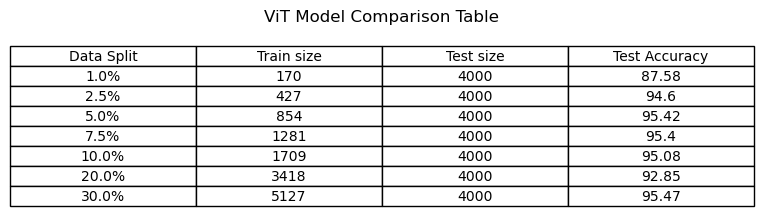

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(test_data)

fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2) 
plt.title('ViT Model Comparison Table', pad=20)
plt.show()

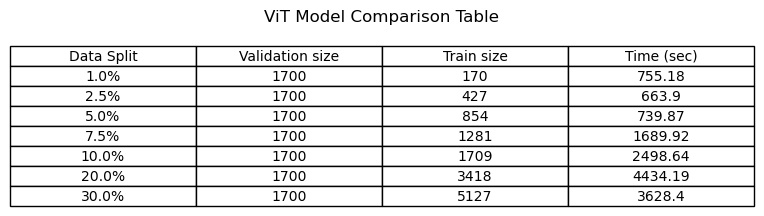

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(time_data)
df = df.drop(["Test size"], axis = 1)
df['Time Taken'] = round(df['Time Taken'], 2)
df.rename(columns={'Time Taken': 'Time (sec)'}, inplace = True)
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2) 
plt.title('ViT Model Comparison Table', pad=20)
plt.show()

In [13]:
def cumulative_list_of_lists(lists):

    for sublist in lists:
        for i in range(1, len(sublist)):
            sublist[i] += sublist[i - 1]
    return lists
cumulative_time_per_epoch = cumulative_list_of_lists(time_per_datasplit_per_epoch)
# print(cumulative_result)

In [14]:
cumulative_time_per_epoch

[[57.664310932159424,
  109.71137261390686,
  160.75000619888306,
  211.89591145515442,
  264.2481803894043,
  317.08677077293396,
  368.9962160587311,
  420.89344358444214,
  471.6202564239502,
  517.613480091095,
  559.8799915313721,
  606.9413628578186,
  656.1855430603027,
  705.5608353614807,
  754.9885177612305],
 [67.55026030540466,
  134.20126581192017,
  201.8949954509735,
  271.76173186302185,
  329.35416769981384,
  362.9765462875366,
  396.3702669143677,
  429.78165435791016,
  463.25260281562805,
  496.54909920692444,
  529.9393649101257,
  563.291351556778,
  596.7515659332275,
  630.2462513446808,
  663.7671086788177],
 [49.490403175354004,
  98.63410997390747,
  147.68709206581116,
  197.12945318222046,
  246.66498184204102,
  296.0088336467743,
  345.5289764404297,
  395.14544653892517,
  444.703165769577,
  493.90383410453796,
  543.1022498607635,
  592.2225377559662,
  641.2040011882782,
  690.2490026950836,
  739.581464767456],
 [65.03470206260681,
  129.40180420875

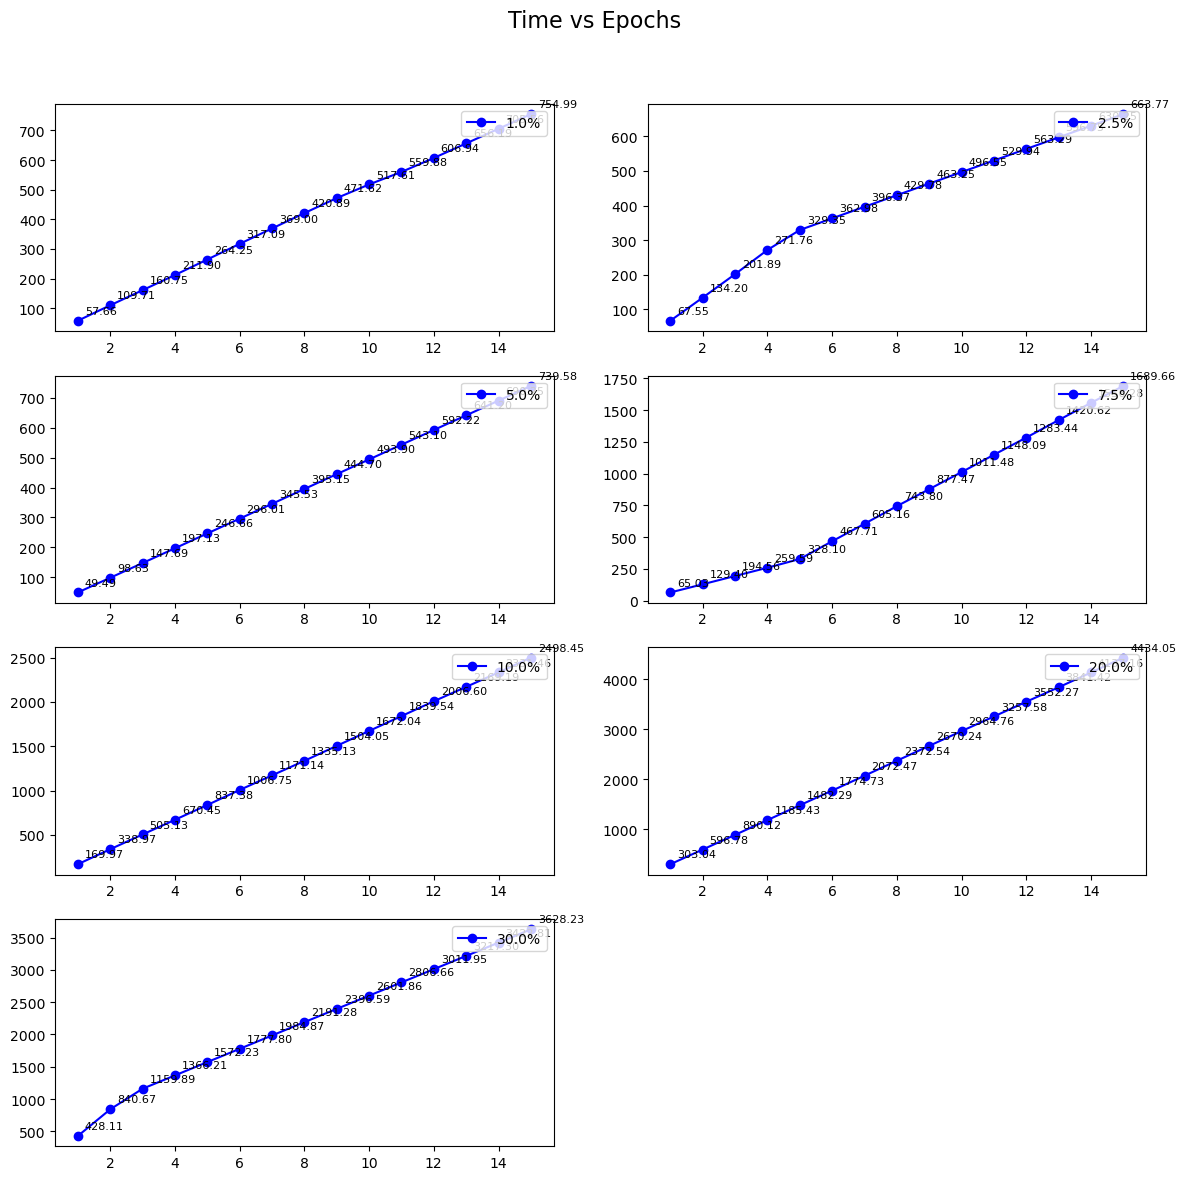

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `cumulative_time_per_epoch` and `dataper` are lists or arrays defined beforehand

fig, axs = plt.subplots(4, 2, figsize=(12, 12))

for i in range(7):
    row = i // 2
    col = i % 2
    x_values = [i for i in range(1, 16)]
    y_values = cumulative_time_per_epoch[i]
    
    # Plot the line with markers
    axs[row, col].plot(x_values, y_values, label=f'{dataper[i]*100}%', marker='o', color='b')
    
    # Annotate each point
    for x, y in zip(x_values, y_values):
        axs[row, col].annotate(f'{y:.2f}', xy=(x, y), xytext=(5, 5),
                               textcoords='offset points', fontsize=8, color='black')
    
    # Add legend
    axs[row, col].legend(loc='upper right')

# Hide the last (8th) unused subplot
fig.delaxes(axs[3, 1])
# fig.delaxes(axs[2, 2])
# Add a title and adjust layout
fig.suptitle('Time vs Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()


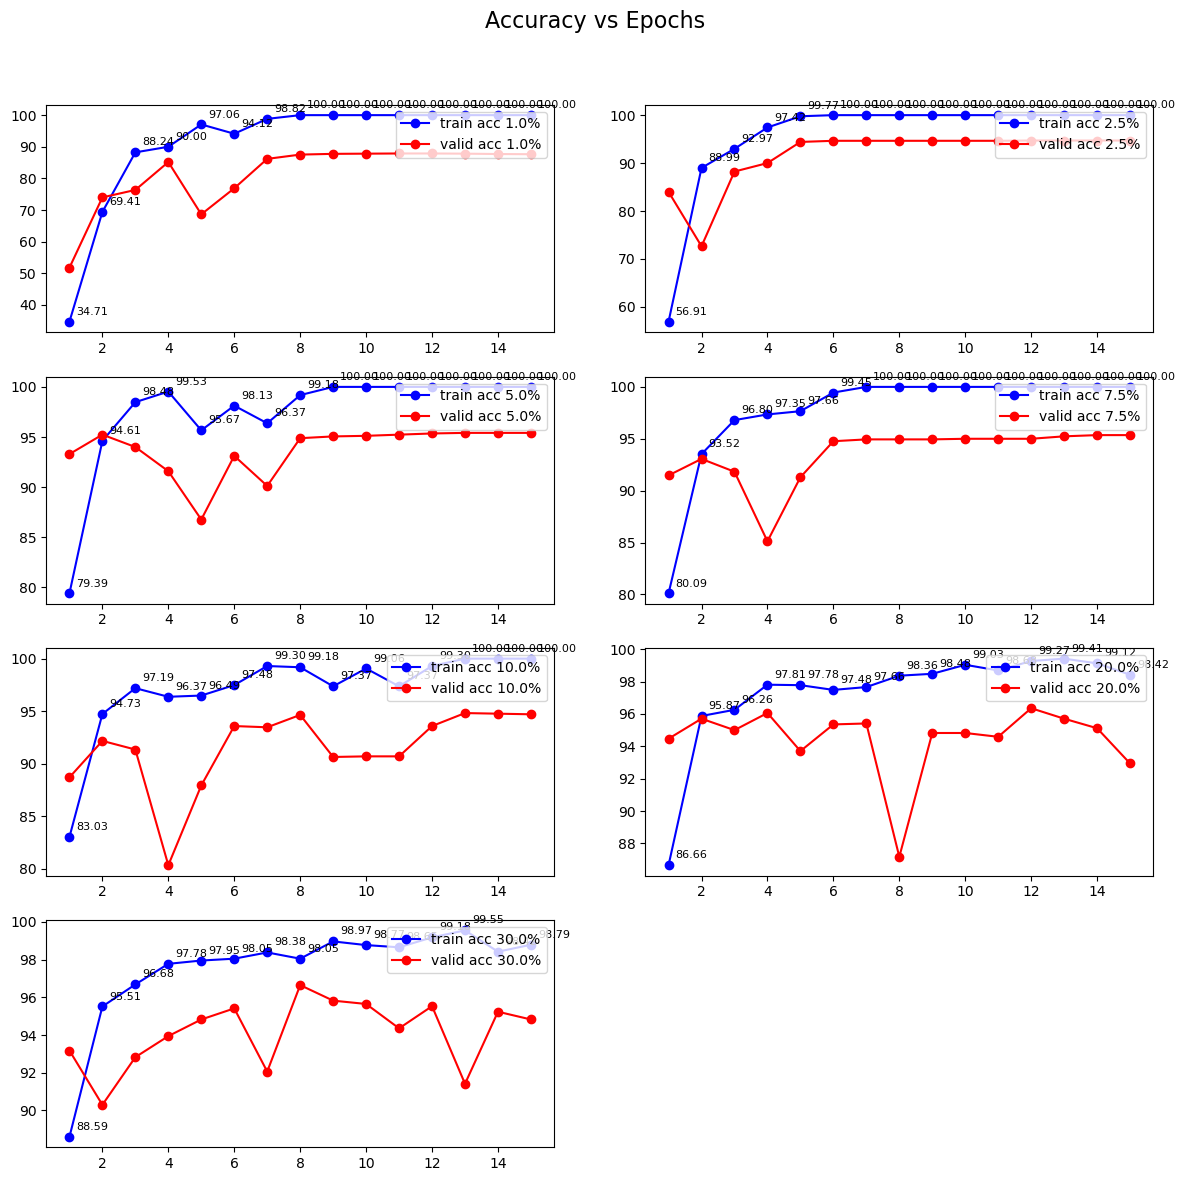

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `cumulative_time_per_epoch` and `dataper` are lists or arrays defined beforehand

fig, axs = plt.subplots(4, 2, figsize=(12, 12))

for i in range(7):
    row = i // 2
    col = i % 2
    x_values = [i for i in range(1, len(cumulative_time_per_epoch[i])+1)]
    y_values = train_acc_all[i]
    
    # Plot the line with markers
    axs[row, col].plot(x_values, y_values, label=f'train acc {dataper[i]*100}%', marker='o', color='b')
    axs[row, col].plot(x_values, val_acc_all[i], label=f'valid acc {dataper[i]*100}%', marker='o', color='r')

    # Annotate each point
    for x, y in zip(x_values, y_values):
        axs[row, col].annotate(f'{y:.2f}', xy=(x, y), xytext=(5, 5),
                               textcoords='offset points', fontsize=8, color='black')
    
    # Add legend
    axs[row, col].legend(loc='upper right')

# Hide the last (8th) unused subplot
fig.delaxes(axs[3, 1])
# fig.delaxes(axs[2, 2])
# Add a title and adjust layout
fig.suptitle('Accuracy vs Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()


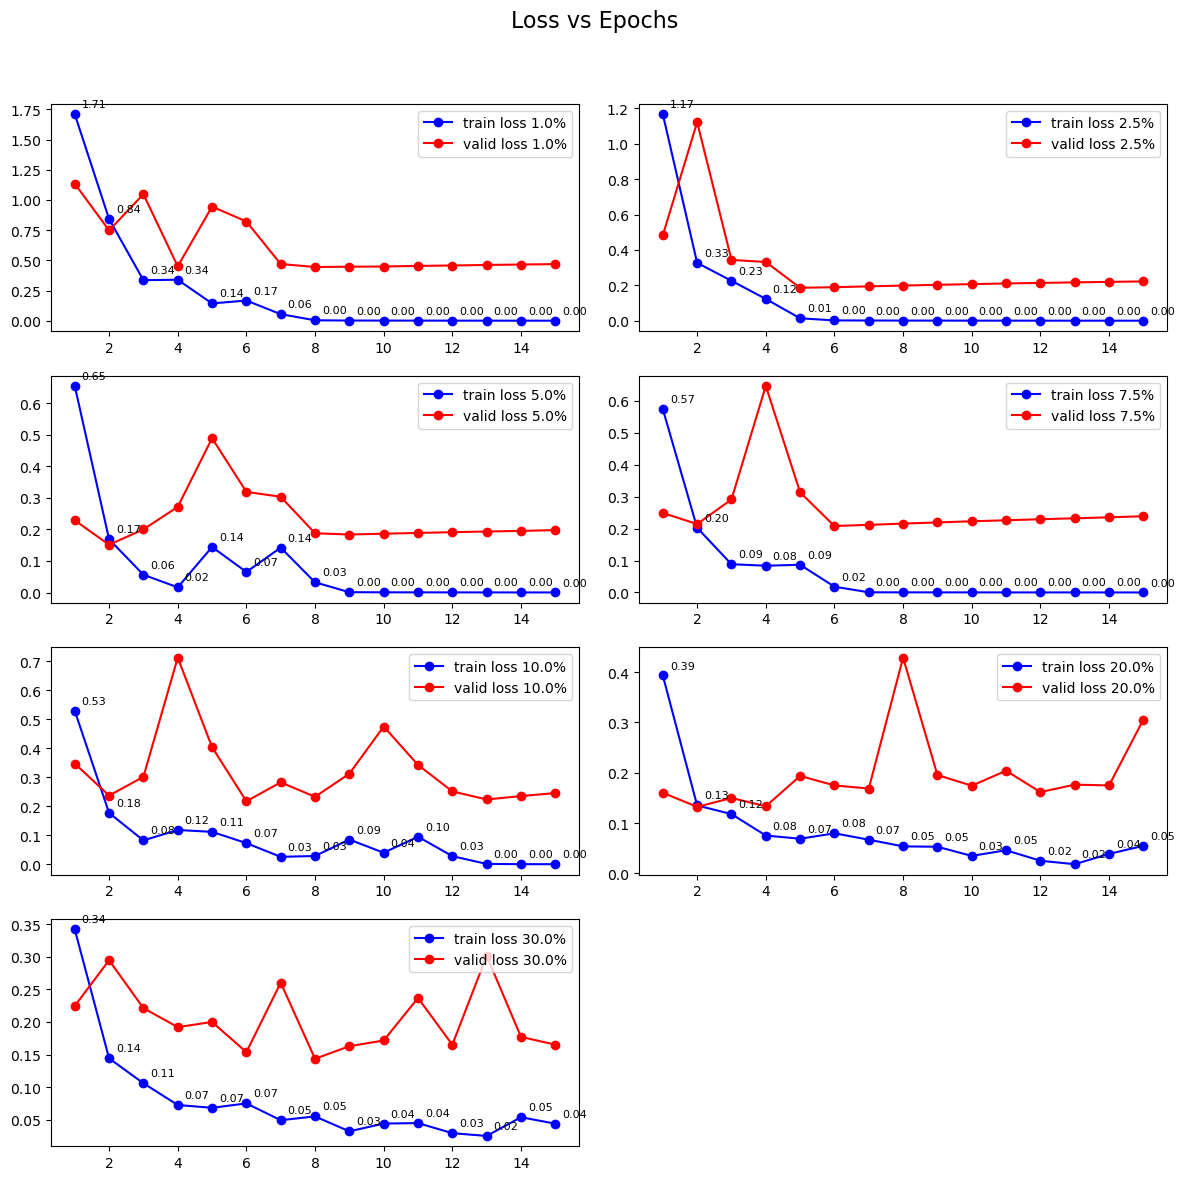

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `cumulative_time_per_epoch` and `dataper` are lists or arrays defined beforehand

fig, axs = plt.subplots(4, 2, figsize=(12, 12))

for i in range(7):
    row = i // 2
    col = i % 2
    x_values = [i for i in range(1, len(cumulative_time_per_epoch[i])+1)]
    y_values = train_loss_all[i]
    
    # Plot the line with markers
    axs[row, col].plot(x_values, y_values, label=f'train loss {dataper[i]*100}%', marker='o', color='b')
    axs[row, col].plot(x_values, val_loss_all[i], label=f'valid loss {dataper[i]*100}%', marker='o', color='r')

    # Annotate each point
    for x, y in zip(x_values, y_values):
        axs[row, col].annotate(f'{y:.2f}', xy=(x, y), xytext=(5, 5),
                               textcoords='offset points', fontsize=8, color='black')
    
    # Add legend
    axs[row, col].legend(loc='upper right')

# Hide the last (8th) unused subplot
fig.delaxes(axs[3, 1])
# fig.delaxes(axs[2, 2])
# Add a title and adjust layout
fig.suptitle('Loss vs Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()
